# Business Challenge

## Description From Origin

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection method

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

But what really is a **fraudulent transfer**? 

A fraudulent transfer, is an attempt to avoid debt by transferring money to another person or company. It is generally a civil, not a criminal matter, meaning that one cannot go to jail for it, but in some jurisdictions there is potential for criminal prosecution.[1] It is generally treated as a civil cause of action that arises in debtor/creditor relations, particularly with reference to insolvent debtors. The cause of action is typically brought by creditors or by bankruptcy trustees.

- **References**: https://en.wikipedia.org/wiki/Fraudulent_conveyance
- **Data**: https://www.kaggle.com/ntnu-testimon/paysim1

## Business Questions

For the development of the project, we created a fictitious company called "Blocker Fraud Company", which is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” in which it guarantees the blocking of fraudulent transactions.

The company's business model is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the client's transactions.

However, the Blocker Fraud Company is expanding in Brazil and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:


- **1** - The company receives 25% of each transaction value truly detected as fraud.
- **2** - The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
- **3** - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

###  What do we need to show? 

- What is the model's Precision and Accuracy?
- How Reliable is the model in classifying transactions as legitimate or fraudulent?
- What is the Expected Billing by the Company if we classify 100% of transactions with the model?

Below you can see the entire development of the project in the following topics.

# 0.0. IMPORTS

## Libraries

In [1]:
# data analytics
import pandas  as pd
import numpy   as np

# helper libraries
from IPython.core.display import HTML
from IPython.display      import Image
import requests
import json
import warnings
import pickle
from tabulate        import tabulate
import inflection

# graphs plot
import seaborn as sns
from matplotlib import pyplot as plt

# data preparation
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# feature selection
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE

# balancing data
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,RandomizedSearchCV

# machine learning
from sklearn.ensemble      import RandomForestClassifier,ExtraTreesClassifier,IsolationForest
from sklearn.linear_model  import SGDClassifier 
from lightgbm                import LGBMClassifier

#metrics
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.calibration     import calibration_curve,CalibratedClassifierCV

#hyperparameter fine tuning
import random
import warnings

# error interpretation
from sklearn.metrics       import mean_absolute_error, mean_squared_error

# deploy model
from scipy           import stats as ss
from flask           import Flask

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 24

    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Data

## 0.2.1. Initial Data

This dataset was derivated from the other notebook "converting", because there had some big modifications on the dataset to developed it on this project.

In [4]:
df_raw = pd.read_csv('syn_finan/fraud_detect/data/fraud_test_det.csv')

In [5]:
df_raw.tail()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,date
1008208,8210,39,CASH_OUT,6311409.28000,C1162922333,6311409.28000,0.00000,C1365125890,68488.84000,6379898.11000,1,0,2017-03-02 15:00:00
1008209,8211,374,TRANSFER,850002.52000,C1685995037,850002.52000,0.00000,C2080388513,0.00000,0.00000,1,0,2017-03-15 14:00:00
1008210,8206,209,CASH_OUT,1258818.82000,C1436118706,1258818.82000,0.00000,C1240760502,503464.50000,1762283.33000,1,0,2017-03-09 17:00:00
1008211,8205,305,TRANSFER,1258818.82000,C1531301470,1258818.82000,0.00000,C1470998563,0.00000,0.00000,1,0,2017-03-12 17:00:00
1008212,8207,594,TRANSFER,339682.13000,C2013999242,339682.13000,0.00000,C1850423904,0.00000,0.00000,1,0,2017-03-24 18:00:00


## 0.2.2. Droping Unnamed Column

In [6]:
df_raw = df_raw.drop('Unnamed: 0', axis=1)

In [7]:
df_raw.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'date'],
      dtype='object')

# 1.0. Step 01 - Data Descriptions

## 1.1. Rename Columns

In [8]:
df1 = df_raw.copy()

In [9]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'date'],
      dtype='object')

In [10]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'date']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [11]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'date'],
      dtype='object')

## 1.2. Data Dimensions

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1008213
Number of Cols: 12


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008213 entries, 0 to 1008212
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1008213 non-null  int64  
 1   type              1008213 non-null  object 
 2   amount            1008213 non-null  float64
 3   name_orig         1008213 non-null  object 
 4   oldbalance_org    1008213 non-null  float64
 5   newbalance_orig   1008213 non-null  float64
 6   name_dest         1008213 non-null  object 
 7   oldbalance_dest   1008213 non-null  float64
 8   newbalance_dest   1008213 non-null  float64
 9   is_fraud          1008213 non-null  int64  
 10  is_flagged_fraud  1008213 non-null  int64  
 11  date              994899 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 92.3+ MB


## 1.3. Data Types

In [14]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
date                 object
dtype: object

## 1.4. Check NA

In [15]:
df1.isna().sum()

step                    0
type                    0
amount                  0
name_orig               0
oldbalance_org          0
newbalance_orig         0
name_dest               0
oldbalance_dest         0
newbalance_dest         0
is_fraud                0
is_flagged_fraud        0
date                13314
dtype: int64

In [16]:
df1[df1['date'] == 'NaT']

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date


## 1.5. Fillout NA

In [17]:
#for i in range(len(df1)):
#   if df1.loc[i, 'date'] == 'NaT':
#    df1.loc[i, 'date'] = df1.loc[i-1, 'date']

In [18]:
#pickle.dump(df1, open('syn_finan/fraud_detect/parameter/df1_na.pkl', 'wb'))
df1 = pickle.load(open('syn_finan/fraud_detect/parameter/df1_na.pkl', 'rb'))

In [19]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
date                0
dtype: int64

## 1.6. Changing Dtypes

In [20]:
df1['date'] = pd.to_datetime(df1['date'])

In [21]:
df1.dtypes

step                         int64
type                        object
amount                     float64
name_orig                   object
oldbalance_org             float64
newbalance_orig            float64
name_dest                   object
oldbalance_dest            float64
newbalance_dest            float64
is_fraud                     int64
is_flagged_fraud             int64
date                datetime64[ns]
dtype: object

## 1.7. Descriptive Statistical

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [23]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, knew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
m

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,step,245.35071,249.00000,144.41473,1.00000,743.00000,742.00000,0.41556,0.36681
1,amount,188715.00408,76320.65000,636031.70145,0.00000,64234448.19000,64234448.19000,26.05246,1283.04048
2,oldbalance_org,843482.50939,14818.00000,2902988.50020,0.00000,59585040.37000,59585040.37000,5.25387,33.31737
3,newbalance_orig,854657.17532,0.00000,2928073.25317,0.00000,49585040.37000,49585040.37000,5.19308,32.32773
4,oldbalance_dest,1098601.73474,130575.14000,3399759.86495,0.00000,355185537.06000,355185537.06000,20.39176,1011.63128
5,newbalance_dest,1226703.55511,215259.59000,3660140.00931,0.00000,355380483.53000,355380483.53000,19.30120,874.63438
6,is_fraud,0.00815,0.00000,0.08989,0.00000,1.00000,1.00000,10.94380,117.76699
7,is_flagged_fraud,0.00002,0.00000,0.00398,0.00000,1.00000,1.00000,251.01892,63008.62500


## 1.8. Checking Outliers

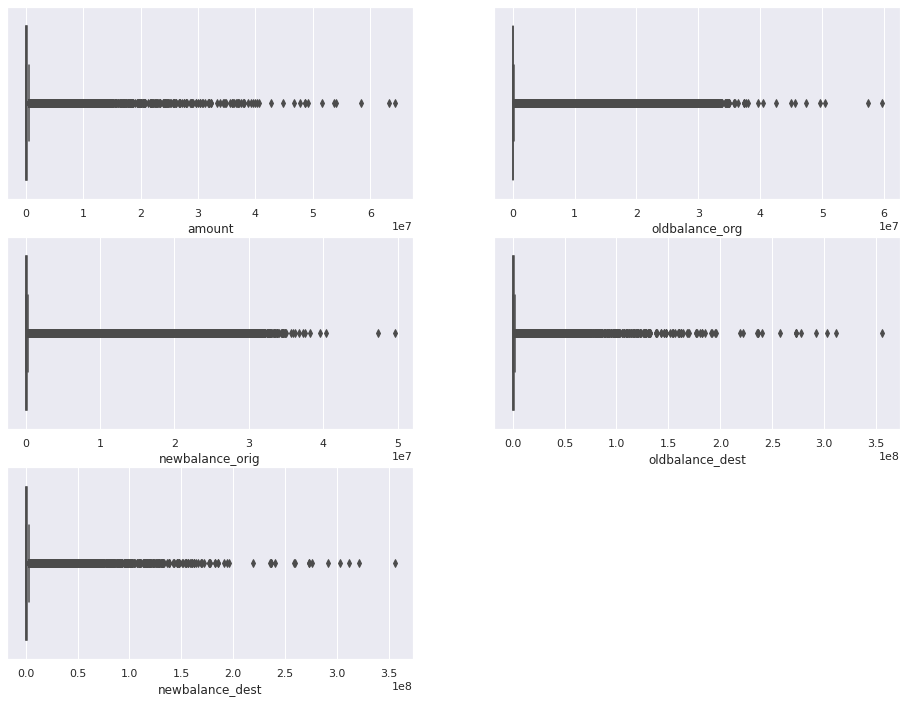

In [24]:
#amount
plt.subplot(3,2,1)
sns.boxplot(df1['amount']);

#oldbalance_org
plt.subplot(3,2,2)
sns.boxplot(df1['oldbalance_org']);

#newbalance_org
plt.subplot(3,2,3)
sns.boxplot(df1['newbalance_orig']);

#oldbalance_dest
plt.subplot(3,2,4)
sns.boxplot(df1['oldbalance_dest']);

#newbalance_dest
plt.subplot(3,2,5)
sns.boxplot(df1['newbalance_dest']);

## 1.7. Checking Distribution

In [25]:
num_attributes.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,181.00000,181.00000,0.00000,0.00000,0.00000,1,0
1,310,962.43000,26770.94000,25808.50000,0.00000,0.00000,0,0
2,162,6688.74000,9207.00000,2518.26000,0.00000,0.00000,0,0
3,42,128487.35000,0.00000,0.00000,701404.75000,1567434.81000,0,0
4,235,83845.22000,10538.00000,0.00000,0.00000,83845.22000,0,0


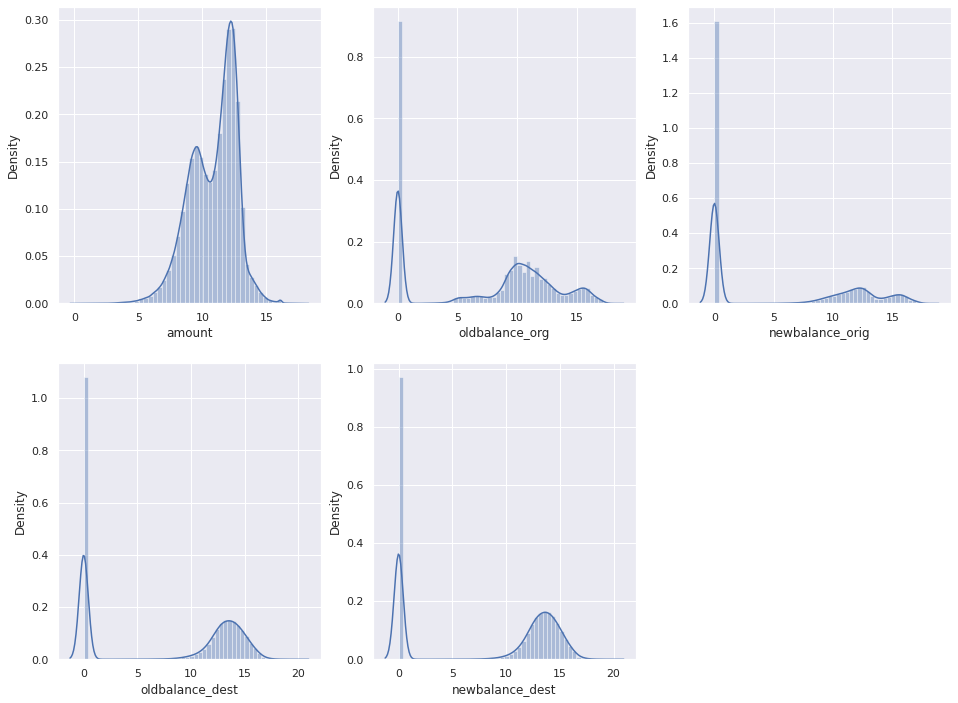

In [26]:
# Normal Distribution Check

# Amount
plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['amount']));

# Old Balance Origin
plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['oldbalance_org']));

# New Balance Origin
plt.subplot(2,3,3)
sns.distplot(np.log1p(num_attributes['newbalance_orig']));

# Old Balance Destiny
plt.subplot(2,3,4)
sns.distplot(np.log1p(num_attributes['oldbalance_dest']));

# New Balance Destiny
plt.subplot(2,3,5)
sns.distplot(np.log1p(num_attributes['newbalance_dest']));

## 1.9. Cattegorical Attributes

In [27]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type               5
name_orig    1008002
name_dest     651556
date             690
dtype: int64

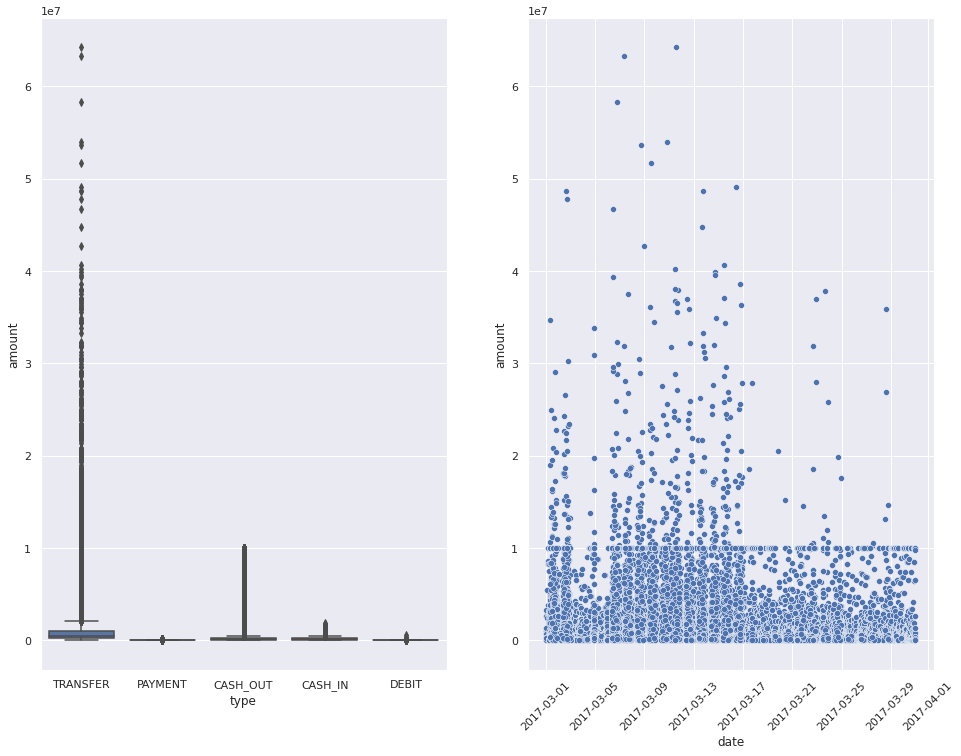

In [28]:
# Checking Outliers By Type
plt.subplot(1, 2, 1)
sns.boxplot(x='type', y='amount', data=df1)

# Checking Outliers By Date
plt.subplot(1, 2, 2)
sns.scatterplot(x='date', y='amount', data=df1);
plt.xticks(rotation=45);

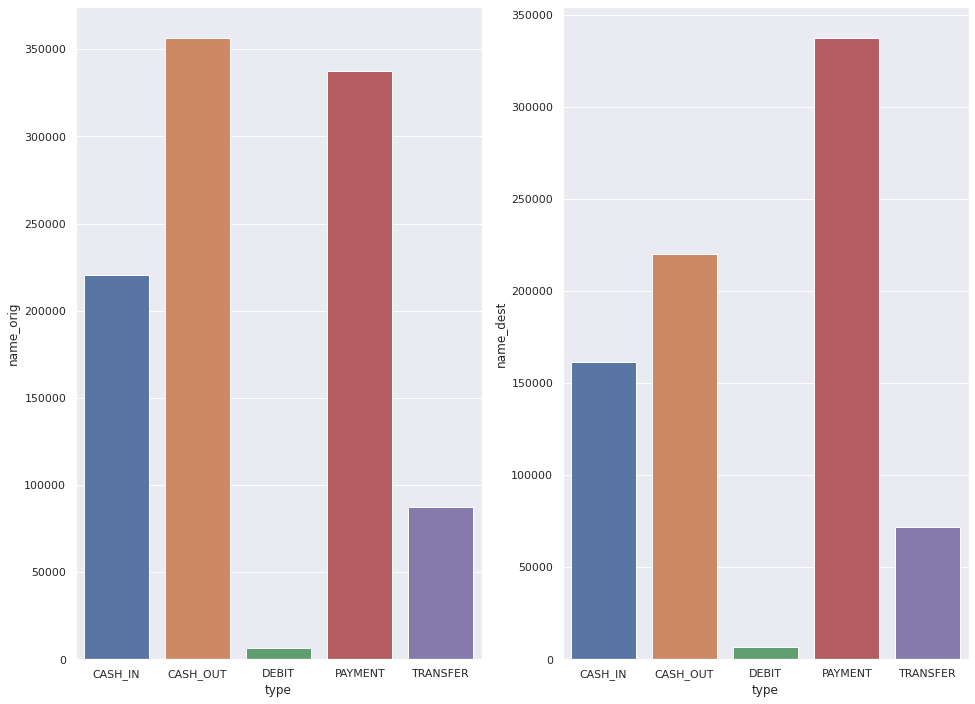

In [29]:
# Checking Quantity of Customers Origin By Type
df1_norig = df1[['type', 'name_orig']].groupby('type').nunique().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(x='type', y='name_orig', data=df1_norig);

# Checking Quantity of Customers Destiny By Type
df1_nodest = df1[['type', 'name_dest']].groupby('type').nunique().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='type', y='name_dest', data=df1_nodest);

# 2.0. Step 02 - Feature Engineering

In [30]:
df2 = df1.copy()

## 2.1. Mindmap

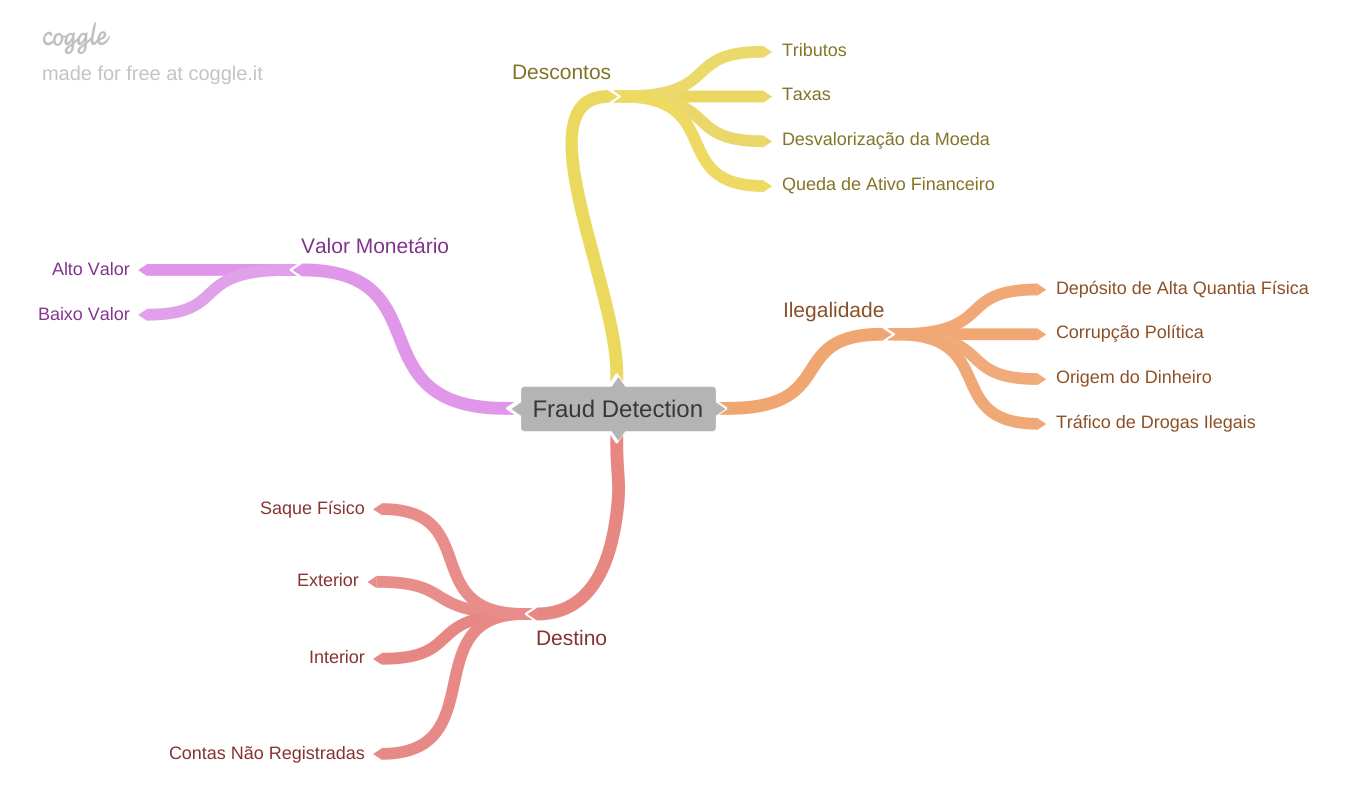

In [31]:
Image('syn_finan/image/fraud_detection.png')

## 2.2. Hypothesis List

**H1.** Transactions on the weekends has more chance to be fraud.

**H2.** The first two weeks of the months has more chances to be fraud.

**H3.** On dawns transactions has more chance to be a fraud.

**H4.** Transactions amounts more than $ 200,000.00 has more chances to be fraud.

**H5.** The type of transactions influences in the chances of be fraud.

**H6.** Transactions with origim accounts with zero values in the initial time has more chances to be fraud.

**H7.** Transaction with origim accounts with zero values in the final time has more chcances to be fraud.

**H8.** Transactions with destiny accounts with zero values in the initial time has more chances to be fraud.

**H9.** Transaction with destiny accounts with zero values in the final time has more chances to be fraud.

## 2.4. Feature Engineering

In [32]:
# hour of day
df2['hour_of_day'] = df2['date'].dt.strftime('%H')
df2['hour_of_day'] = df2['hour_of_day'].astype(int64)

# days of Week
df2['day_of_week'] = df2['date'].dt.dayofweek # Monday = 0, Sunday = 6.
 
# Weeks of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week # First Week = 9, Last Week = 13

# customer Types
df2['client_orig'] = df2['name_orig'].apply(lambda x: 1 if 'M' in x else 0)
df2['client_dest'] = df2['name_dest'].apply(lambda x: 1 if 'M' in x else 0)

# Zero or Not
df2['zero_new_orig'] = df2['newbalance_orig'].apply(lambda x: 1 if x == 0 else 0)
df2['zero_old_orig'] = df2['oldbalance_org'].apply(lambda x: 1 if x == 0 else 0)
df2['zero_new_dest'] = df2['newbalance_dest'].apply(lambda x: 1 if x == 0 else 0)
df2['zero_old_dest'] = df2['oldbalance_dest'].apply(lambda x: 1 if x == 0 else 0)

In [33]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,...,date,hour_of_day,day_of_week,week_of_year,client_orig,client_dest,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest
0,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,...,2017-03-01 01:00:00,1,2,9,0,0,1,0,1,1
1,310,PAYMENT,962.43000,C1831141281,26770.94000,25808.50000,M1705277839,0.00000,0.00000,0,...,2017-03-12 22:00:00,22,6,10,0,1,0,0,1,1
2,162,PAYMENT,6688.74000,C1377301456,9207.00000,2518.26000,M938199512,0.00000,0.00000,0,...,2017-03-07 18:00:00,18,1,10,0,1,0,0,1,1
3,42,CASH_OUT,128487.35000,C50503805,0.00000,0.00000,C747464370,701404.75000,1567434.81000,0,...,2017-03-02 18:00:00,18,3,9,0,0,1,1,0,0
4,235,TRANSFER,83845.22000,C1386020581,10538.00000,0.00000,C990398217,0.00000,83845.22000,0,...,2017-03-10 19:00:00,19,4,10,0,0,1,0,0,1


# 3.0. Step 03 - Filtering Variables

In [34]:
df3 = df2.copy()

In [35]:
df3.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,...,date,hour_of_day,day_of_week,week_of_year,client_orig,client_dest,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest
0,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,...,2017-03-01 01:00:00,1,2,9,0,0,1,0,1,1
1,310,PAYMENT,962.43000,C1831141281,26770.94000,25808.50000,M1705277839,0.00000,0.00000,0,...,2017-03-12 22:00:00,22,6,10,0,1,0,0,1,1
2,162,PAYMENT,6688.74000,C1377301456,9207.00000,2518.26000,M938199512,0.00000,0.00000,0,...,2017-03-07 18:00:00,18,1,10,0,1,0,0,1,1
3,42,CASH_OUT,128487.35000,C50503805,0.00000,0.00000,C747464370,701404.75000,1567434.81000,0,...,2017-03-02 18:00:00,18,3,9,0,0,1,1,0,0
4,235,TRANSFER,83845.22000,C1386020581,10538.00000,0.00000,C990398217,0.00000,83845.22000,0,...,2017-03-10 19:00:00,19,4,10,0,0,1,0,0,1


## 3.1. Filtering Rows

In [36]:
df3 = df3[(df3['client_dest'] == 0)]

## 3.2. Filtering Columns

I'm excluding 'name_orig' and 'name_dest' because they don't show variability, the same to 'client_orig' and 'client_dest'.

The 'step' was replaced by 'date' column, then this columns is not necessary more.

In [37]:
# Excluding Explained Columns On Other Variables
df3 = df3.drop(['name_orig', 'name_dest', 'client_orig', 'client_dest', 'step'], axis=1)

In [38]:
df3.columns

Index(['type', 'amount', 'oldbalance_org', 'newbalance_orig',
       'oldbalance_dest', 'newbalance_dest', 'is_fraud', 'is_flagged_fraud',
       'date', 'hour_of_day', 'day_of_week', 'week_of_year', 'zero_new_orig',
       'zero_old_orig', 'zero_new_dest', 'zero_old_dest'],
      dtype='object')

# 4.0. Step 04 - Exploratoring Analysis of Data

In [39]:
df4 = df3.copy()

## 4.1. Univariable Analysis

### 4.1.1. Numerical Variable

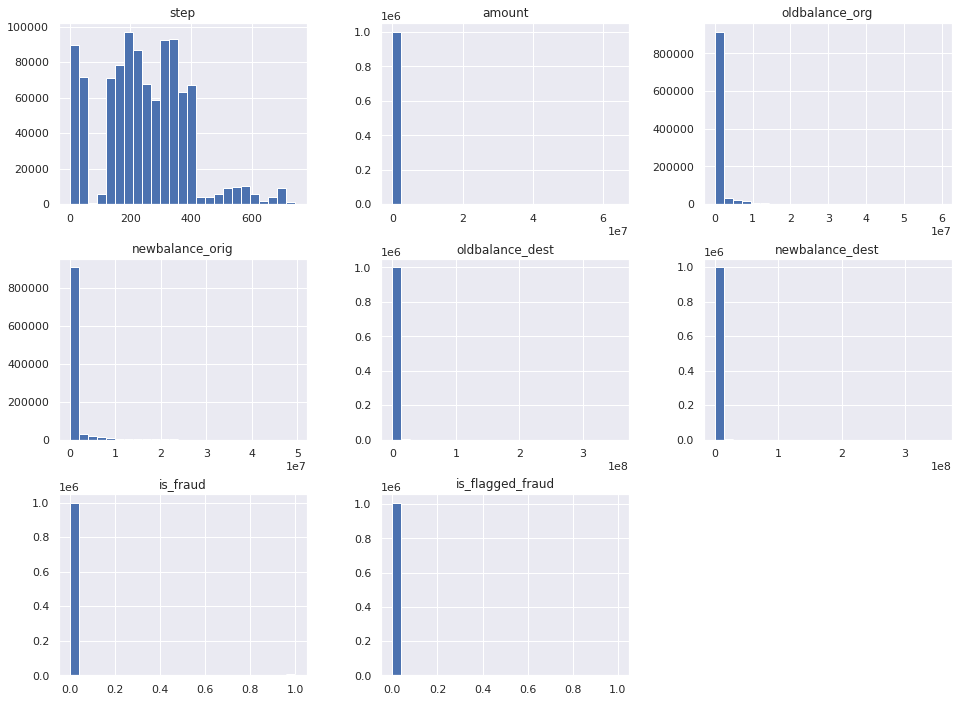

In [40]:
num_attributes.hist(bins=25);

## 4.2. Bivariable Analysis

### **H1.** Transactions on the weekends has more chance to be fraud. (True)

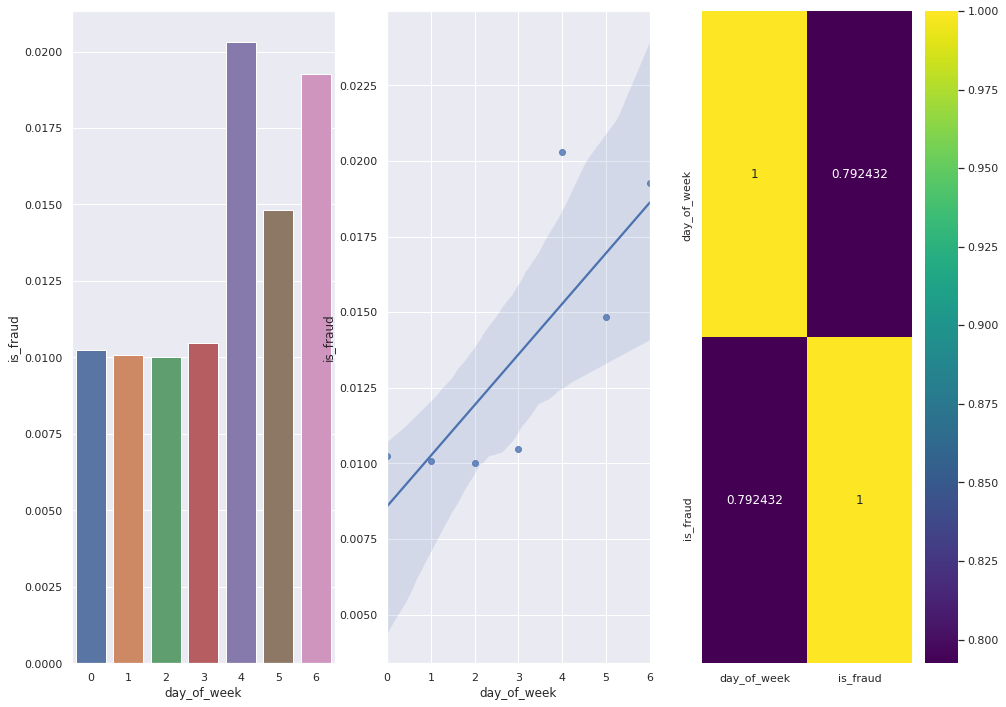

In [41]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'is_fraud']].groupby('day_of_week').mean().reset_index()
sns.barplot(x='day_of_week', y='is_fraud', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='is_fraud', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H2.** The first two weeks of the months has more chances to be fraud. (False - Insight)

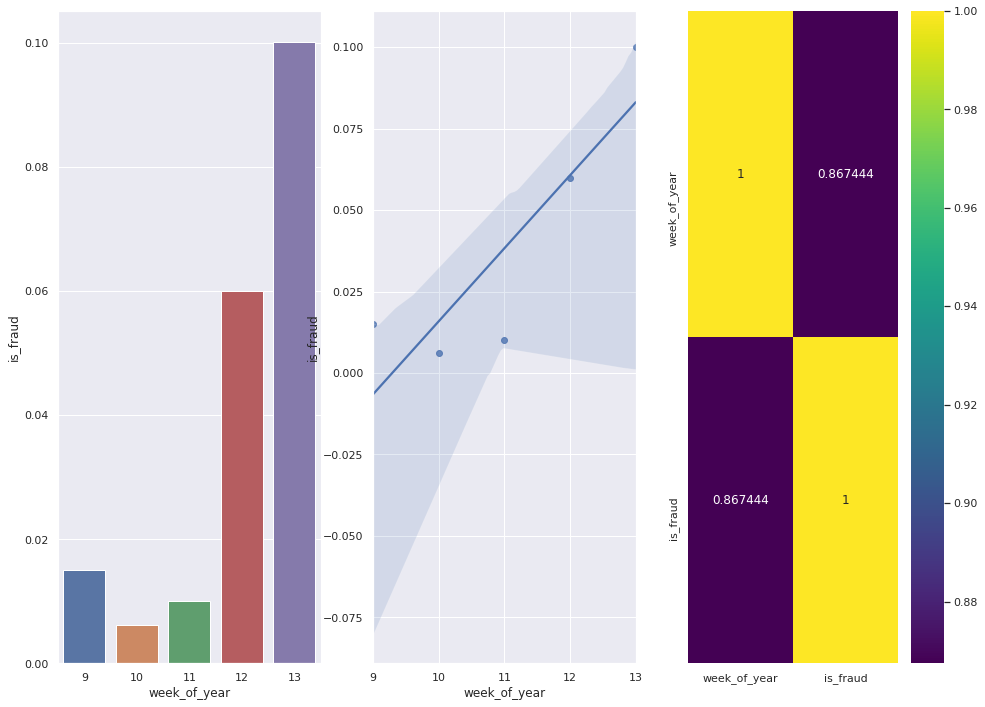

In [42]:
plt.subplot(1, 3, 1)
aux1 = df4[['week_of_year', 'is_fraud']].groupby('week_of_year').mean().reset_index()
sns.barplot(x='week_of_year', y='is_fraud', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='week_of_year', y='is_fraud', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H3.** On dawns transactions has more chance to be a fraud. (True)

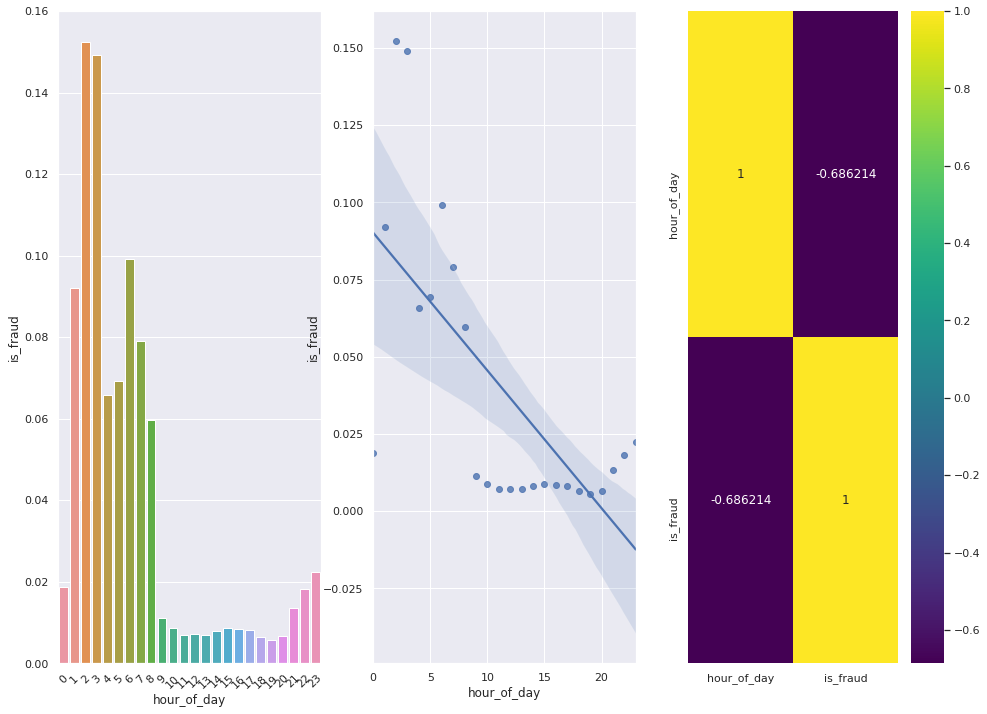

In [43]:
plt.subplot(1, 3, 1)
aux1 = df4[['hour_of_day', 'is_fraud']].groupby('hour_of_day').mean().reset_index()
sns.barplot(x='hour_of_day', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='hour_of_day', y='is_fraud', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True, fmt="g", cmap='viridis');

### **H4.** Transactions amounts more than $ 200,000.00 has more chances to be fraud. (True)

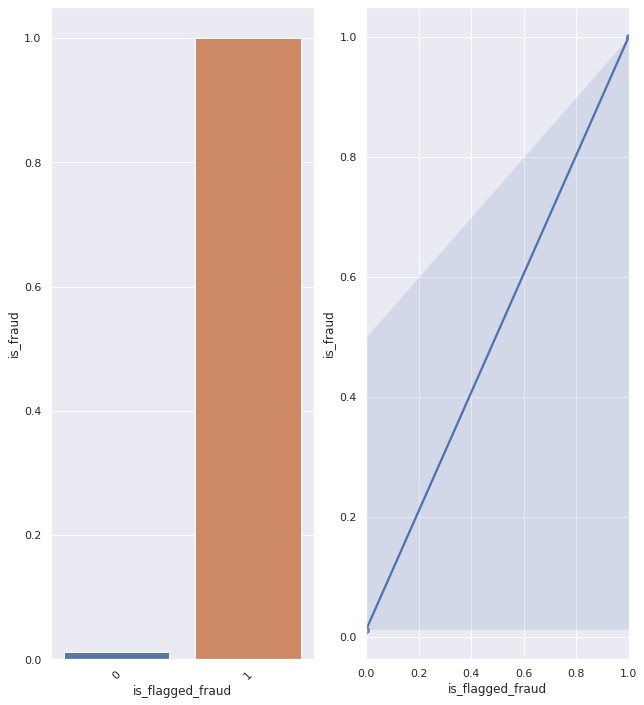

In [44]:
plt.subplot(1, 3, 1)
aux1 = df4[['is_flagged_fraud', 'is_fraud']].groupby('is_flagged_fraud').mean().reset_index()
sns.barplot(x='is_flagged_fraud', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='is_flagged_fraud', y='is_fraud', data=aux1);

### **H5.** Cash out transactions has more chances to be fraud. (False - Insight)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'CASH_OUT'),
  Text(2, 0, 'DEBIT'),
  Text(3, 0, 'TRANSFER')])

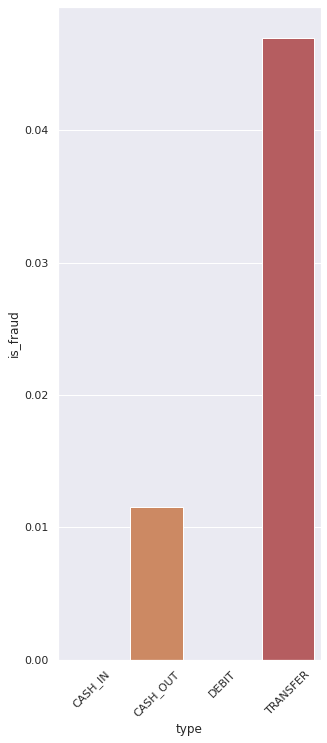

In [45]:
plt.subplot(1, 3, 1)
aux1 = df4[['type', 'is_fraud']].groupby('type').mean().reset_index()
sns.barplot(x='type', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

### **H6.** Transactions with origim accounts with zero values in the initial time has more chances to be fraud. (False - Insight)

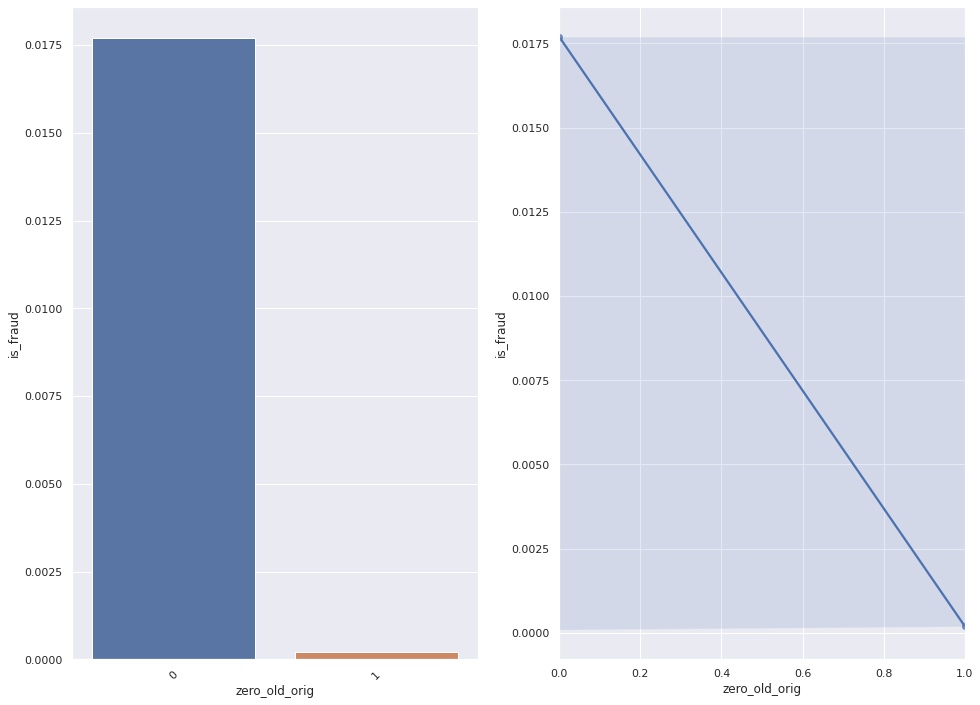

In [46]:
plt.subplot(1, 2, 1)
aux1 = df4[['zero_old_orig', 'is_fraud']].groupby('zero_old_orig').mean().reset_index()
sns.barplot(x='zero_old_orig', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.regplot(x='zero_old_orig', y='is_fraud', data=aux1);

### **H7.** Transactions with origim accounts with zero values in the final time has more chances to be fraud. (False)

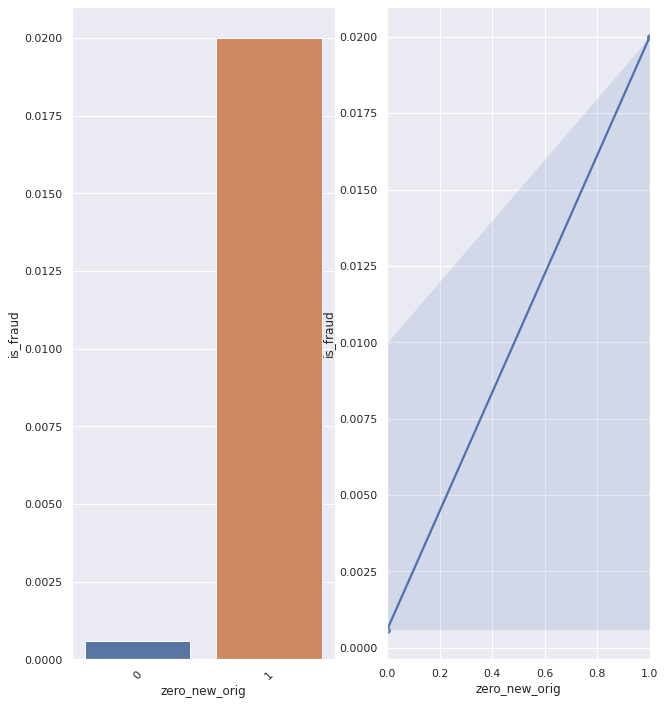

In [47]:
plt.subplot(1, 3, 1)
aux1 = df4[['zero_new_orig', 'is_fraud']].groupby('zero_new_orig').mean().reset_index()
sns.barplot(x='zero_new_orig', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='zero_new_orig', y='is_fraud', data=aux1);

### **H8.** Transactions with destiny accounts with zero values in the initial time has more chances to be fraud. (True)

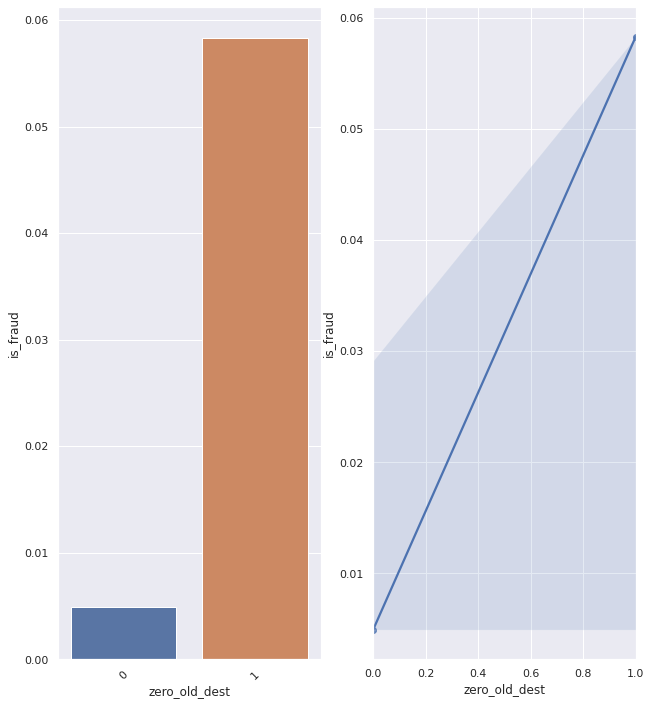

In [48]:
plt.subplot(1, 3, 1)
aux1 = df4[['zero_old_dest', 'is_fraud']].groupby('zero_old_dest').mean().reset_index()
sns.barplot(x='zero_old_dest', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='zero_old_dest', y='is_fraud', data=aux1);

### **H9.** Transaction with destiny accounts with zero values in the final time has more chances to be fraud. (True)

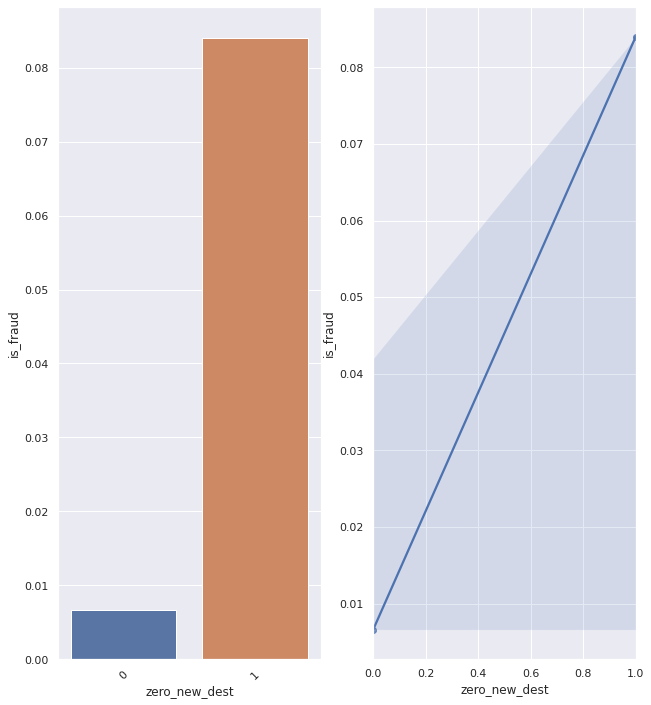

In [49]:
plt.subplot(1, 3, 1)
aux1 = df4[['zero_new_dest', 'is_fraud']].groupby('zero_new_dest').mean().reset_index()
sns.barplot(x='zero_new_dest', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='zero_new_dest', y='is_fraud', data=aux1);

### 4.2.1. Hypothesis Sumary

In [50]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'False', 'High'],
       ['H3', 'True', 'High'],
       ['H4', 'True', 'High'],
       ['H5', 'False', 'High'],
       ['H6', 'False', 'High'],
       ['H7', 'True', 'High'],
       ['H8', 'True', 'High'],
       ['H9', 'True', 'High']]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            False         High
H3            True          High
H4            True          High
H5            False         High
H6            False         High
H7            True          High
H8            True          High
H9            True          High


## 4.3. Multivariable Analysis

### 4.2.1. Correlations

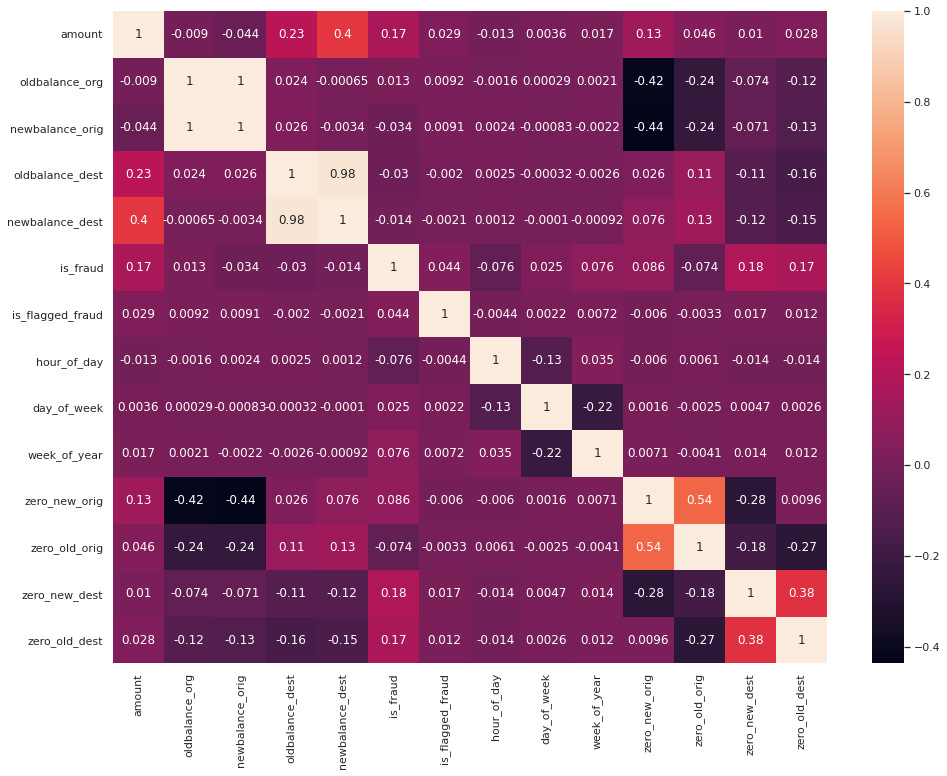

In [51]:
correlation = df4.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0. Step 05 - Data Preparation

In [52]:
df5 = df4.copy()

### 5.1.1. Post Analysis - Filtering Rows

These columns was filtered because they don't have frauds of this types in the dataset.

In [53]:
df5 = df5[(df5['type'] != 'CASH_IN') & (df5['type'] != 'DEBIT')]

## 5.2. Encoding Variables

In [54]:
df5 = pd.get_dummies(df5, prefix=['type'], columns=['type'])

## 5.3. Rescaling

In [55]:
df5.head()

,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date,hour_of_day,day_of_week,week_of_year,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest,type_CASH_OUT,type_TRANSFER
0,181.00000,181.00000,0.00000,0.00000,0.00000,1,0,2017-03-01 01:00:00,1,2,9,1,0,1,1,0,1
3,128487.35000,0.00000,0.00000,701404.75000,1567434.81000,0,0,2017-03-02 18:00:00,18,3,9,1,1,0,0,1,0
4,83845.22000,10538.00000,0.00000,0.00000,83845.22000,0,0,2017-03-10 19:00:00,19,4,10,1,0,0,1,0,1
6,345858.07000,21523.00000,0.00000,0.00000,45881.29000,0,0,2017-03-13 15:00:00,15,0,11,1,0,0,1,0,1
8,98247.27000,107181.00000,8933.73000,0.00000,54985.05000,0,0,2017-03-02 10:00:00,10,3,9,0,0,0,1,1,0


In [56]:
a = df5.select_dtypes(include=['int64', 'float64'])

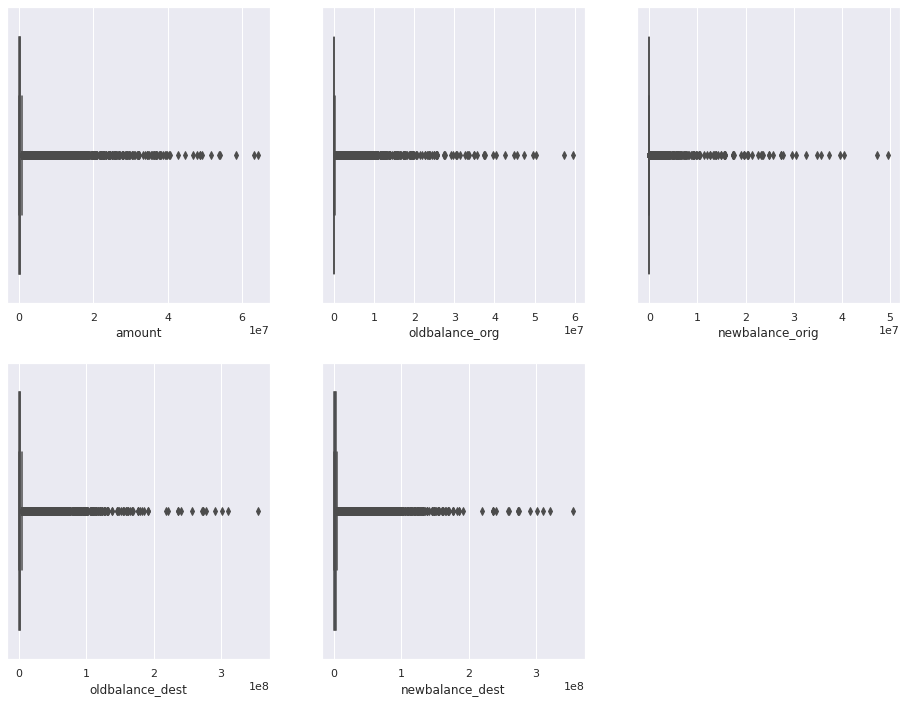

In [57]:
# amount
plt.subplot(2, 3, 1)
sns.boxplot(df5['amount']);

# oldbalance_org
plt.subplot(2, 3, 2)
sns.boxplot(df5['oldbalance_org']);

# newbalance_orig
plt.subplot(2, 3, 3)
sns.boxplot(df5['newbalance_orig']);

# oldbalance_dest
plt.subplot(2, 3, 4)
sns.boxplot(df5['oldbalance_dest']);

# newbalance_dest
plt.subplot(2, 3, 5)
sns.boxplot(df5['newbalance_dest']);

In [58]:
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform( df5[['amount']].values )
pickle.dump(df5['amount'], open('syn_finan/fraud_detect/parameter/amount_parameter.pkl', 'wb'))
#df5['amount'] = pickle.load(open('syn_finan/fraud_detect/parameter/amount_parameter.pkl', 'rb'))

# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform( df5[['oldbalance_org']].values )
pickle.dump(df5['oldbalance_org'], open('syn_finan/fraud_detect/parameter/oldbalance_org_parameter', 'wb'))
#df5['oldbalance_org'] = pickle.load(open('syn_finan/fraud_detect/parameter/oldbalance_org_parameter', 'rb'))

# newbalance_orig
df5['newbalance_orig'] = rs.fit_transform( df5[['newbalance_orig']].values )
pickle.dump(df5['newbalance_orig'], open('syn_finan/fraud_detect/parameter/newbalance_orig_parameter.pkl', 'wb'))
#df5['newbalance_orig'] = pickle.load(open('syn_finan/fraud_detect/parameter/newbalance_orig_parameter.pkl', 'rb'))

# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform( df5[['oldbalance_dest']].values )
pickle.dump(df5['oldbalance_dest'], open('syn_finan/fraud_detect/parameter/oldbalance_dest_parameter', 'wb'))
#df5['oldbalance_dest'] = pickle.load(open('syn_finan/fraud_detect/parameter/oldbalance_dest_parameter', 'rb'))

# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform( df5[['newbalance_dest']].values )
pickle.dump(df5['newbalance_dest'], open('syn_finan/fraud_detect/parameter/newbalance_dest_parameter.pkl', 'wb'))
#df5['newbalance_dest'] = pickle.load(open('syn_finan/fraud_detect/parameter/newbalance_dest_parameter.pkl', 'rb'))

In [59]:
df5.head()

,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date,hour_of_day,day_of_week,week_of_year,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest,type_CASH_OUT,type_TRANSFER
0,-0.75708,-0.00893,0.00000,-0.34101,-0.45830,1,0,2017-03-01 01:00:00,1,2,9,1,0,1,1,0,1
3,-0.19361,-0.01445,0.00000,0.09993,0.41958,0,0,2017-03-02 18:00:00,18,3,9,1,1,0,0,1,0
4,-0.38966,0.30683,0.00000,-0.34101,-0.41134,0,0,2017-03-10 19:00:00,19,4,10,1,0,0,1,0,1
6,0.76101,0.64174,0.00000,-0.34101,-0.43261,0,0,2017-03-13 15:00:00,15,0,11,1,0,0,1,0,1
8,-0.32641,3.25326,8933.73000,-0.34101,-0.42751,0,0,2017-03-02 10:00:00,10,3,9,0,0,0,1,1,0


## 5.4. Transformation

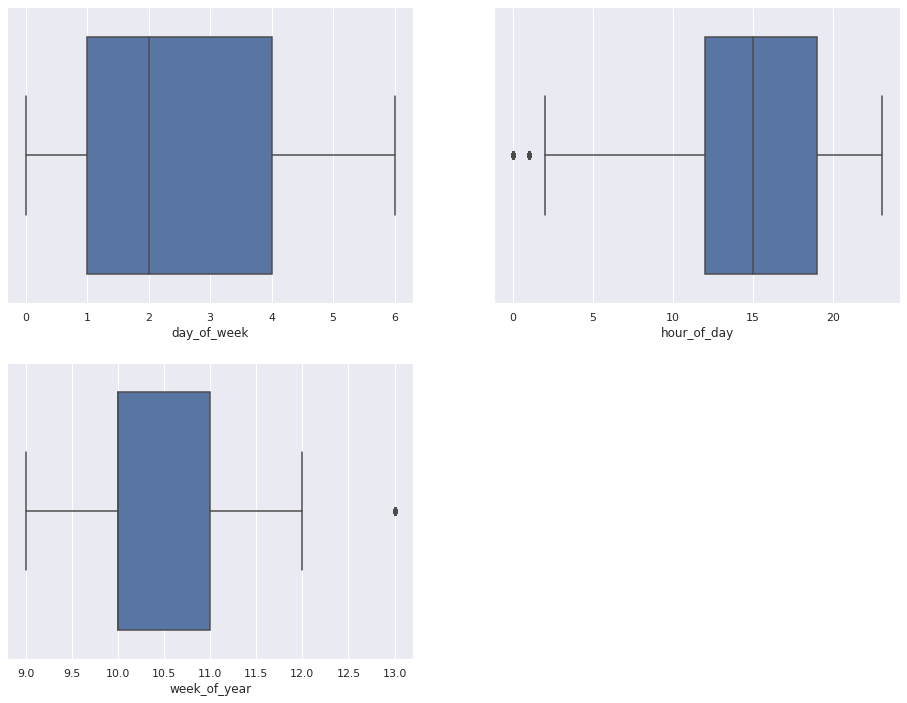

In [60]:
# day_of_week
plt.subplot(2, 2, 1)
sns.boxplot(df5['day_of_week']);

# hour_of_day
plt.subplot(2, 2, 2)
sns.boxplot(df5['hour_of_day']);

# week_of_year
plt.subplot(2, 2, 3)
sns.boxplot(df5['week_of_year']);

In [61]:
mms = MinMaxScaler()

# day_of_week
df5['day_of_week'] = mms.fit_transform( df5[['day_of_week']].values )
pickle.dump(df5['day_of_week'], open('syn_finan/fraud_detect/parameter/day_of_week_parameter.pkl', 'wb'))
#df5['day_of_week'] = pickle.load(open('syn_finan/fraud_detect/parameter/day_of_week_parameter.pkl', 'rb'))

# hour_of_day
df5['hour_of_day'] = mms.fit_transform( df5[['hour_of_day']].values )
pickle.dump(df5['hour_of_day'], open('syn_finan/fraud_detect/parameter/hour_of_day_parameter.pkl', 'wb'))
#df5['hour_of_day'] = pickle.load(open('syn_finan/fraud_detect/parameter/newbalance_dest_parameter.pkl', 'rb'))

# week_of_year
df5['week_of_year'] = mms.fit_transform( df5[['week_of_year']].values )
pickle.dump(df5['week_of_year'], open('syn_finan/fraud_detect/parameter/week_of_year_parameter.pkl', 'wb'))
#df5['newbalance_orig'] = pickle.load(open('syn_finan/fraud_detect/parameter/week_of_year_parameter.pkl', 'rb'))

# 6.0. Step 06 - Feature Selection

In [62]:
df6 = df5.drop('date', axis=1).copy()

In [64]:
X = df6.drop(columns = 'is_fraud', axis = 1)
Y = df6['is_fraud']

## 6.0.1. Manual Selected

In [65]:
manual = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest',
       'newbalance_dest', 'is_flagged_fraud', 'hour_of_day',
       'day_of_week', 'week_of_year', 'encoded_type', 'zero_new_orig',
       'zero_old_orig', 'zero_new_dest', 'zero_old_dest']

## 6.1. Recursive Feature Elimination (RFE)

In [68]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#feature selector
selector = RFE(rf, n_features_to_select = 7, step = 1)
selector = selector.fit(X,Y)

#get ranking
selector.support_

pickle.dump(selector, open('syn_finan/fraud_detect/parameter/selector_parameter.pkl', 'wb'))
#selector = pickle.load(open('syn_finan/fraud_detect/parameter/selector_parameter.pkl', 'rb'))

KeyboardInterrupt: 

In [ ]:
rfe_selected = X.loc[:, selector.support_]
rfe_selected.columns

## 6.2. Boruta as a Feature Selector

In [ ]:
#define model
extra_model = ExtraTreesClassifier(n_jobs=-1)

#split data 
X_train_nn = X.values
y_train_nn = y.values.ravel()

#define boruta
boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_nn, y_train_nn)
pickle.dump(boruta, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'wb'))
#boruta = pickle.load(open('syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'rb'))

#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

## 6.3. Cols Final

In [65]:
df6.head()

,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,hour_of_day,day_of_week,week_of_year,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest,type_CASH_OUT,type_TRANSFER
0,-0.75708,-0.00893,0.00000,-0.34101,-0.45830,1,0,0.04348,0.33333,0.00000,1,0,1,1,0,1
3,-0.19361,-0.01445,0.00000,0.09993,0.41958,0,0,0.78261,0.50000,0.00000,1,1,0,0,1,0
4,-0.38966,0.30683,0.00000,-0.34101,-0.41134,0,0,0.82609,0.66667,0.25000,1,0,0,1,0,1
6,0.76101,0.64174,0.00000,-0.34101,-0.43261,0,0,0.65217,0.00000,0.50000,1,0,0,1,0,1
8,-0.32641,3.25326,8933.73000,-0.34101,-0.42751,0,0,0.43478,0.50000,0.00000,0,0,0,1,1,0


In [224]:
# columns selected
cols_final = ['amount',
 'oldbalance_org',
 'newbalance_dest',
 'hour_of_day',
 'day_of_week',
 'week_of_year',
 'zero_new_dest',
 'zero_old_dest',
 'is_flagged_fraud',
 'type_CASH_OUT',
 'type_TRANSFER']

# columns to add
feat_to_add = ['is_fraud']

# cols added
cols_final.extend(feat_to_add)

# 7.0. Step 07 - Machine Learning Modeling

In [225]:
df7 = df6[cols_final].copy()

## 7.1. Derivating Data

In [226]:
#target variable and features split 
X = df7.drop(columns = 'is_fraud',axis = 1)
y = df7['is_fraud']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## 7.2. LGBMClassifier + Cross Validation

In [90]:
#define model
lgbm = LGBMClassifier(n_jobs = -1)

#train_model
#lgbm.fit(X_train.values, y_train.values)
#pickle.dump(lgbm, open('syn_finan/fraud_detect/models/lgbm.pkl', 'wb'))
lgbm = pickle.load(open('syn_finan/fraud_detect/models/lgbm.pkl', 'rb'))

#predict model
#yhat_lgbm = lgbm.predict(X_test)
#pickle.dump(yhat_lgbm, open('syn_finan/fraud_detect/models/yhat_lgbm.pkl', 'wb'))
yhat_lgbm = pickle.load(open('syn_finan/fraud_detect/models/yhat_lgbm.pkl', 'rb'))

#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130637
           1       0.91      0.83      0.87      2456

    accuracy                           1.00    133093
   macro avg       0.95      0.91      0.93    133093
weighted avg       1.00      1.00      1.00    133093



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

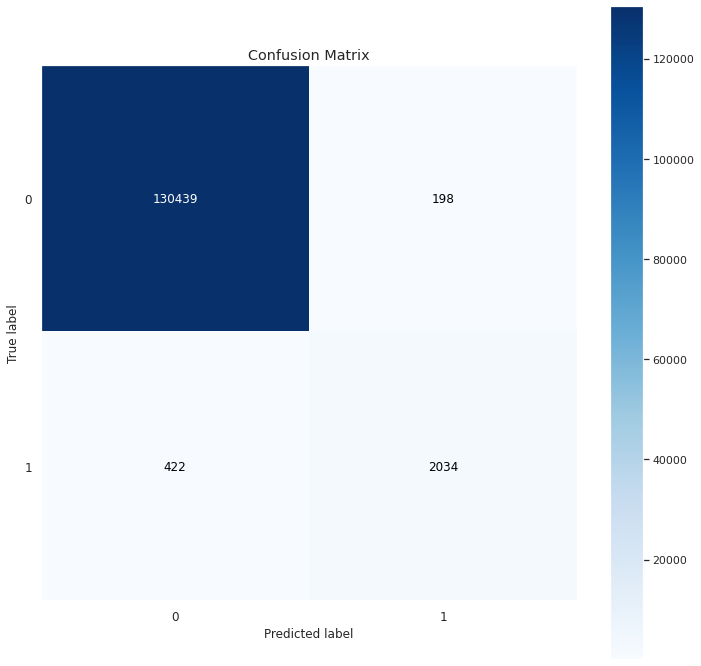

In [91]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (12,12))

## 7.2.1. Cross Validation LGBM

In [101]:
#cross validation scores
#lgbm_cv = cross_val_score(lgbm, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(lgbm_cv, open('syn_finan/fraud_detect/models/lgbm_cv.pkl', 'wb'))
lgbm_cv = pickle.load(open('syn_finan/fraud_detect/models/lgbm_cv.pkl', 'rb'))

In [103]:
#mean and standard deviation
lgbm_true = "Average LGBM: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),6))

## 7.3. RandomForestClassifier


In [76]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#training model
#rf.fit(X_train, y_train)
#pickle.dump(rf, open('syn_finan/fraud_detect/models/rf.pkl', 'wb'))
rf = pickle.load(open('syn_finan/fraud_detect/models/rf.pkl', 'rb'))

#predict model
#yhat_rf = rf.predict(X_test)
#pickle.dump(yhat_rf, open('syn_finan/fraud_detect/models/yhat_rf.pkl', 'wb'))
yhat_rf = pickle.load(open('syn_finan/fraud_detect/models/yhat_rf.pkl', 'rb'))

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130637
           1       0.97      0.79      0.87      2456

    accuracy                           1.00    133093
   macro avg       0.99      0.89      0.93    133093
weighted avg       1.00      1.00      1.00    133093



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

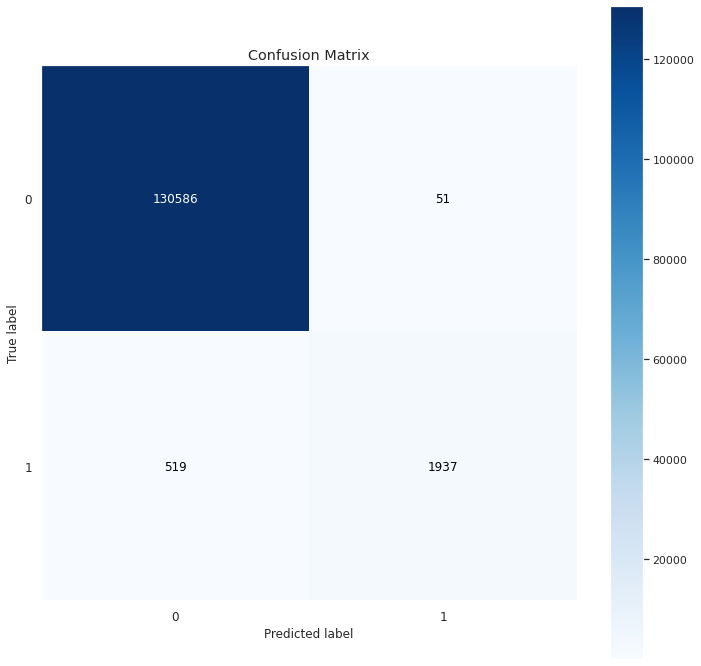

In [77]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize = (12,12))

## 7.3.1. Cross Validation Random Forest

In [79]:
#cross validation scores
#rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(rf_cv, open('syn_finan/fraud_detect/models/rf_cv.pkl', 'wb'))
rf_cv = pickle.load(open('syn_finan/fraud_detect/models/rf_cv.pkl', 'rb'))

In [80]:
#mean and standard deviation
rf_true = "Average RF: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),6))

## 7.4. Stochastic Gradient Descent

In [82]:
#model definition
sgb = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

#fit model
#sgb.fit(X_train,y_train)
#pickle.dump(sgb, open('syn_finan/fraud_detect/models/sgb.pkl', 'wb'))
sgb = pickle.load(open('syn_finan/fraud_detect/models/sgb.pkl', 'rb'))

#prediction
#yhat_sgb = sgb.predict(X_test)
#pickle.dump(yhat_sgb, open('syn_finan/fraud_detect/models/yhat_sgb.pkl', 'wb'))
yhat_sgb = pickle.load(open('syn_finan/fraud_detect/models/yhat_sgb.pkl', 'rb'))

#performance
result_sgb = pd.DataFrame(["Stochastic Gradient Descent",accuracy_score(y_test,yhat_sgb),cohen_kappa_score(y_test,yhat_sgb),
                          recall_score(y_test,yhat_sgb), f1_score(y_test,yhat_sgb),
                          precision_score(y_test,yhat_sgb)]).T
result_sgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_sgb))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    130637
           1       0.86      0.40      0.54      2456

    accuracy                           0.99    133093
   macro avg       0.92      0.70      0.77    133093
weighted avg       0.99      0.99      0.99    133093



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

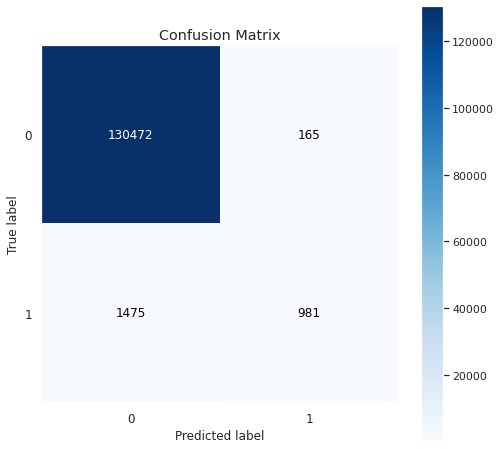

In [83]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_sgb, normalize = False, figsize = (8,8))

## 7.4.1. Cross Validation SGB

In [84]:
#cross validation scores
#sgb_cv = cross_val_score(sgb,X_train, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(sgb_cv, open('syn_finan/fraud_detect/models/sgb_cv.pkl', 'wb'))
sgb_cv = pickle.load(open('syn_finan/fraud_detect/models/sgb_cv.pkl', 'rb'))

In [85]:
#mean and standard deviation
sgb_true = "Average SGB: {} +/- Std {}".format(np.round(np.mean(sgb_cv),4),np.round(np.std(sgb_cv),6))

## 7.5. Machine Learning Performance

In [86]:
#concat each performance as a dataframe
performance = pd.concat([result_rf,result_lgbm,result_sgb])
performance.sort_values('Precision_score', ascending = False)

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.99572,0.86958,0.78868,0.87174,0.97435
0,LGBM Classifier,0.99534,0.86538,0.82818,0.86775,0.91129
0,Stochastic Gradient Descent,0.98768,0.53929,0.39943,0.54470,0.85602


## 7.5.1. Cross Validation Performance

In [104]:
print(lgbm_true)
print(rf_true)
print(sgb_true)

Average LGBM: 0.9954 +/- Std 0.001337
Average RF: 0.996 +/- Std 0.000348
Average SGB: 0.9891 +/- Std 0.001071


# 8.0. Step 08 - Hyperparameter Fine Tuning

## 8.1. Random Search

In [105]:
#define model
rf_tuned = RandomForestClassifier(n_jobs = -1, random_state = 42)

#parameters
param =  {'max_depth': np.arange(2, 12, 2), 
         'n_estimators': np.arange(45, 155, 60)}

#define random search cv
rf_tuned_cv = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
#rf_tuned_cv.fit(X_train, np.ravel(y_train))

#pickle.dump(rf_tuned_cv, open('syn_finan/fraud_detect/models/rf_tuned_cv.pkl', 'wb'))
rf_tuned_cv = pickle.load(open('syn_finan/fraud_detect/models/rf_tuned_cv.pkl', 'rb'))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [106]:
rf_tuned_cv.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=105, n_jobs=-1,
                       random_state=42)

## 8.2. Tuned Model

In [227]:
#define model
rf_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#training model
rf_tuned.fit(X_train, y_train)
pickle.dump(rf_tuned, open('syn_finan/fraud_detect/models/rf_tuned.pkl', 'wb'))
#rf = pickle.load(open('syn_finan/fraud_detect/models/rf_tuned.pkl', 'rb'))

#predict model
yhat_rf_tuned = rf_tuned.predict(X_test)
pickle.dump(yhat_rf_tuned, open('syn_finan/fraud_detect/models/yhat_rf_tuned.pkl', 'wb'))
#yhat_rf_tuned = pickle.load(open('syn_finan/fraud_detect/models/yhat_rf_tuned.pkl', 'rb'))

#performance
result_rf_tuned = pd.DataFrame(["Random Forest Classifier Tuned",accuracy_score(y_test,yhat_rf_tuned),cohen_kappa_score(y_test,yhat_rf_tuned),
                          recall_score(y_test,yhat_rf_tuned), f1_score(y_test,yhat_rf_tuned),
                           precision_score(y_test,yhat_rf_tuned)]).T
result_rf_tuned.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf_tuned))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    130637
           1       0.99      0.71      0.83      2456

    accuracy                           0.99    133093
   macro avg       0.99      0.86      0.91    133093
weighted avg       0.99      0.99      0.99    133093



In [108]:
result_rf_tuned

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier Tuned,0.99446,0.82197,0.70684,0.82470,0.98974


## 8.3. Fine Tuning RF Cross Validation

In [109]:
#cross validation scores
#rf_tuned_cv = cross_val_score(rf_tuned,X_train, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(rf_tuned_cv, open('syn_finan/fraud_detect/models/rf_tuned_cv.pkl', 'wb'))
rf_tuned_cv = pickle.load(open('syn_finan/fraud_detect/models/rf_tuned_cv.pkl', 'rb'))

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_tuned_cv),4),np.round(np.std(rf_tuned_cv),4)))

Average: 0.9948 +/- Std 0.0004


# 9.0. Step 09 - Business Performance

## 9.1. Parameteres Review

- **1** - The company receives 25% of each transaction value truly detected as fraud.
- **2** - The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
- **3** - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

## 9.2. Business Performance

In [207]:
# creating predictions columns
X_test['is_fraud'] = y_test
X_test['predictions'] = yhat_rf_tuned
X_test['gross'] = rs.inverse_transform(X_test[['amount']])

In [218]:
X_test.shape

(133093, 15)

In [222]:
# 1 - The company receives 25% of each transaction value truly detected as fraud.
a1 = X_test[(X_test['predictions'] == 1) & (X_test['is_fraud'] == 1)]
a1['profit'] = a1.loc[:, 'gross']*0.0025 
print('1. With transactions detected as fraud and truly as fraud the Block Fraud earned ${:,.2f}'
      .format(a1['profit'].sum()))

# 2 - The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
a1 = X_test[(X_test['predictions'] == 1) & (X_test['is_fraud'] == 0)]
a1['profit'] = a1.loc[:, 'gross']*0.0005 
print('\n2. With transactions detected as fraud, but in truth detected legitimate the Block Fraud earned ${:,.2f}'
      .format(a1['profit'].sum()))

# 3 - The company gives back 100% of the value for the customer in each transaction detected as legitimate, 
# however the transaction is actually a fraud.
a1 = X_test[(X_test['predictions'] == 0) & (X_test['is_fraud'] == 1)]
a1['profit'] = a1.loc[:, 'gross']*0.001 
print('\n3. With transactions detected as legitimate, but in truth as fraud the Block Fraud returned ${:,.2f}'
      .format(a1['profit'].sum()))

print('\nThe total database test in this situation was with 133093 transactions.')

1. With transactions detected as fraud and truly as fraud the Block Fraud earned $63,232,835.63

2. With transactions detected as fraud, but in truth detected legitimate the Block Fraud earned $25,604.72

3. With transactions detected as legitimate, but in truth as fraud the Block Fraud returned $825,711.76

The total database test in this situation was with 133093 transactions.


# 10.0. Step 10 - Making The Deployment

## 10.1. Training Model to Deployment

In [239]:
#target variable and features split 
#df7 = df7.drop('week_of_year', axis=1)
df7['oldbalance_dest'] = df6['oldbalance_dest'].copy() 
X = df7.drop(columns = 'is_fraud',axis = 1)
y = df7['is_fraud']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [241]:
#define model
rf_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#training model
rf_tuned.fit(X_train, y_train)
pickle.dump(rf_tuned, open('syn_finan/fraud_detect/models/rf_tuned.pkl', 'wb'))
#rf = pickle.load(open('syn_finan/fraud_detect/models/rf_tuned.pkl', 'rb'))

#predict model
yhat_rf_tuned = rf_tuned.predict(X_test)
pickle.dump(yhat_rf_tuned, open('syn_finan/fraud_detect/models/yhat_rf_tuned.pkl', 'wb'))
#yhat_rf_tuned = pickle.load(open('syn_finan/fraud_detect/models/yhat_rf_tuned.pkl', 'rb'))

#performance
result_rf_tuned = pd.DataFrame(["Random Forest Classifier Tuned",accuracy_score(y_test,yhat_rf_tuned),cohen_kappa_score(y_test,yhat_rf_tuned),
                          recall_score(y_test,yhat_rf_tuned), f1_score(y_test,yhat_rf_tuned),
                           precision_score(y_test,yhat_rf_tuned)]).T
result_rf_tuned.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf_tuned))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    130637
           1       0.99      0.71      0.83      2456

    accuracy                           0.99    133093
   macro avg       0.99      0.85      0.91    133093
weighted avg       0.99      0.99      0.99    133093



## 10.2. Deployment

In [238]:
X_test.columns

Index(['amount', 'oldbalance_org', 'newbalance_dest', 'hour_of_day',
       'day_of_week', 'zero_new_dest', 'zero_old_dest', 'is_flagged_fraud',
       'type_CASH_OUT', 'type_TRANSFER'],
      dtype='object')

In [ ]:
import pickle
import streamlit as st
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
import datetime

#load the trained model
model = pickle.load(open('rf_tuned.pkl', 'rb'))

# defining the prediction function
def prediction(Amount, OrigimOldBalance, DestinyNewBalance, DestinyOldBalance, HourofDay, DayofWeek,
                ZeroNewDest, ZeroOldDest, FlaggedFraud, type_CASH_OUT, type_TRANSFER):

    # making the prediction
    yhat = model.predict([[Amount, OrigimOldBalance, DestinyNewBalance, DestinyOldBalance, HourofDay, DayofWeek,
                ZeroNewDest, ZeroOldDest, FlaggedFraud, type_CASH_OUT, type_TRANSFER]])
    
    # giving the answer
    prediction = (yhat)
    
    return prediction
    
def main():
    st.header('Fraud Detector')
    st.text("Author: Valcilio Eugenio - Data Scientist")
    
    # defining Amount and FlaggedFraud
    Amount = st.number_input('Total amount of this transaction', value=0)
    
    if Amount >= 200000:
        FlaggedFraud = 1
        
    elif Amount < 200000:
        FlaggedFraud = 0
    #FlaggedFraud = Amount.apply(lambda x: 1 if x >= 200000 else 0)
        
    # defining Origim Balances
    OrigimOldBalance = st.number_input('Original amount of the origim account', value=0)
    DestinyOldBalance = st.number_input('Original amount of the destiny account', value=0)
    DestinyNewBalance = st.number_input('Pos transaction amount of the destiny account', value=0)
    if DestinyNewBalance == 0:
        ZeroNewDest = 1
        
    elif DestinyNewBalance > 0:
        ZeroNewDest = 0
    #ZeroNewDest = DestinyNewBalance.apply(lambda x: 1 if x == 0 else 0)
    
    if DestinyOldBalance == 0:
         ZeroOldDest = 1
        
    elif DestinyOldBalance > 0:
        ZeroOldDest = 0
    #ZeroOldDest = DestinyOldBalance.apply(lambda x: 1 if x == 0 else 0)
    
    # defining date variables
    DayofWeek = st.selectbox('Day of the transaction (0 - monday, 1 - tuesday, 2 - wednesday, 3 - thursday, 
                             '4 - friday, 5 - saturday, 6 - sunday', 
    [0, 1, 2, 3, 4, 5, 6])
    HourofDay = st.number_input('Hour of the transaction', value=0)
    
    # defining type transaction
    Type = st.selectbox('Type of the transaction', ['Cash Out', 'Transfer'])
    
    if Type == 'Cash Out':
    	CashOut = 1
    	
    elif Type != 'Cash Out':
    	CashOut = 0
    	
    if Type == 'Transfer':
    	Transfer = 1
    	
    elif Type != 'Transfer':
    	Transfer = 0
    
    
    #CashOut = st.selectbox('The transaction was a Cash Out? 0 - no, 1- yes', [0, 1])
    #Transfer = st.selectbox('The transaction was a Transfer? 0 - no, 1 - yes', [0, 1])
    
    # defining result
    result = ''
    final_result = ''
    
    if st.button('Predict'):
        #making the prediction
        result = prediction(Amount, OrigimOldBalance, DestinyNewBalance, DestinyOldBalance, HourofDay, DayofWeek,
                ZeroNewDest, ZeroOldDest, FlaggedFraud, CashOut, Transfer)
        
        # converting and showing result
        
        if result == 1:
        	result_final = 'fraud'
        	
        elif result == 0:
        	result_final = 'legitimate'
        	
        st.success('The transaction is: {}'.format(result_final))
        
if __name__ == '__main__':
    main()